# Photogrammetry Example

In [138]:
import logging
logging.basicConfig()
logging.getLogger("cedalion").setLevel(logging.DEBUG)
logging.getLogger('trame_client').setLevel(logging.WARNING)
logging.getLogger('trame_server').setLevel(logging.WARNING)

import cedalion.io
import cedalion.plots
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor
import xarray as xr
import pyvista as pv
import numpy as np
import cedalion.geometry.registration
import cedalion.dataclasses as cdc
from cedalion.plots import OptodeSelector




from cedalion.geometry.landmarks import order_ref_points_6
from cedalion.geometry.registration import icp_with_full_transform, find_spread_points

xr.set_options(display_expand_data=False);





<module 'cedalion.geometry.registration' from '/Users/masha/Documents/Uni/AlexLab/cedalion/cedalion/src/cedalion/geometry/registration.py'>

## Choose between interactive and static 3D plots

In [100]:
pv.set_jupyter_backend("static")  # uncomment for static rendering
#pv.set_jupyter_backend("client")  # uncomment for interactive rendering

Use `cedalion.io.read_einstar_obj` to read the textured triangle mesh produced by the Einstar scanner.

In [141]:
path_to_obj_file = ""
s = cedalion.io.read_einstar_obj(path_to_obj_file)

Processors are meant to analyze the textured mesh and extract positions. The ColoredStickerProcessor searches for colored circular areas. The colors must be specified by their ranges in hue and value. These can for example be found by usig a color pipette tool on the texture file.

In the following to classes of stickers are searched: "O(ptodes)" in blue and "L(andmarks" in yellow.

In [118]:
processor = ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.7, 1)), # (hue_min, hue_max, value_min, value_max)
        #"L" : ((0.25, 0.37, 0.35, 0.6))
    }
)

In [119]:
sticker_centers, normals, details = processor.process(s, details=True)

[[ 75.588409  40.123718 452.155945]
 [ 75.1884    40.123718 452.188782]
 [ 74.788406  40.123718 452.215576]
 ...
 [107.649712 112.571342 399.528473]
 [109.057274  77.41523  284.200592]
 [109.057274  77.41523  284.200592]]
[[ 75.588409  40.123718 452.155945]
 [ 75.1884    40.123718 452.188782]
 [ 74.788406  40.123718 452.215576]
 ...
 [162.995621   4.923721 389.31897 ]
 [162.683212   4.523727 389.31897 ]
 [161.991013   3.723724 389.31897 ]]
O (0.11, 0.21, 0.7, 1)
[0.09084368 0.03052839 0.10707354 0.23410139 0.09764936 0.11341352
 0.39883623 0.07840315 0.03647173 0.30065596 0.09160932 0.11272505
 0.06626543 0.08361982 0.05356184 0.09709368 0.03484453 0.09632769
 0.1893062  0.13699812 0.00778669 0.09379839 0.47435198 0.08235491
 0.03245893 0.01833296 0.05088701 0.08386335 0.30185347 0.03686811
 0.11998884 0.15678389 0.20428266 0.08062578 0.00980329 0.03609724
 0.06496416 0.09267927 0.10368147 0.23539385 0.10264997 0.00481428
 0.10959856 0.00981794 0.28458269 0.06140825]
6.115082835321841


/Users/masha/Documents/Uni/AlexLab/cedalion/cedalion/src/cedalion/geometry/photogrammetry/processors.py:356: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  detail_coords = np.array(detail_coords)[sorted_indices]
/Users/masha/Documents/Uni/AlexLab/cedalion/cedalion/src/cedalion/geometry/photogrammetry/processors.py:357: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  detail_colors = np.array(detail_colors)[sorted_indices]


In [120]:
display(sticker_centers)

Magnitude,[[142.59588476898298 6.568571620341323 418.8786296121232] [112.23926838618087 19.902060719664746 255.31506572101625] [127.19655451073385 5.928837608214078 267.79395237783666] [141.36381419674953 -17.570654557356036 403.91920532609936] [98.11391293393935 80.51432672248986 258.5443930400329] [52.836701615830776 21.59285983848861 244.81348703318372] [119.4895605824585 52.947358545318956 439.0724297317951] [97.58137791576524 60.633526052820585 253.19230368829375] [134.72238432479077 17.872589594905506 429.39152905144516] [78.95162506661194 53.18591261139984 247.4544555522999] [105.63348533027171 -7.02065294448185 435.28629134500267] [112.67992084107223 1.346866635035683 260.0713800451626] [56.162700712975756 68.89831227390002 251.8149386179519] [161.22385334986802 5.2710650318344765 395.40031019684517] [102.3416611881505 -25.739824069378255 274.31747012494014] [96.61639100363115 39.43580677983894 249.5799458828701] [71.83251810631755 7.025518706108268 246.98977683140888] [131.8664125131598 53.5418292073464 266.4287141470766] [114.39061281405287 5.842091440467828 437.44393102978245] [108.25340315611663 61.28955512341952 444.8616635542737] [82.0666021692765 -21.644825347040054 434.5042149442732] [80.10909915036075 38.49497695088318 451.59419584911893] [96.0893822006412 20.057059010514642 248.91464452904106] [124.76338551010409 -4.2643362511283796 427.762587472925] [84.70145972525106 -10.339866986525863 256.0756214660176] [88.19375153372033 5.671522001332386 444.4150852505852] [66.65690383445192 -3.47005230973768 444.66702055562797] [53.304030411307885 53.75562686907269 247.90387330903596] [148.40240390733857 23.649804358045763 420.40951003193567] [150.4910751353695 31.478963610705048 279.3889945930635] [76.70755534427168 29.823584319350246 245.03365363925047] [120.20614891739561 -29.337262143201052 415.41758999104877] [101.62263342548613 45.55364638821206 447.1630255437344] [72.32754686333809 16.755797112901472 449.81121558024256] [85.65327860113237 99.08194743706292 264.3536353057495] [116.49915798726613 27.95075009418824 442.4856840064792] [132.14016265690617 30.590707018503654 264.5407040096815] [74.6732982076009 78.81820118835665 255.21593622908844] [134.85136684330948 35.741193286169235 432.2075109846364] [49.84995185869384 10.200838976392104 448.8786048894638] [99.17536625771906 -34.26341558332977 419.78775343564877] [115.94993046725432 -42.70115066653714 399.47919781743826] [93.57023854044155 21.05995153508086 447.7201490983525] [118.64183800477859 68.41153803589715 262.6537646581167] [36.24103098414839 42.817518204613876 247.01984405883908] [115.1926018456472 49.7200851924242 256.967691555789]]
Units,millimeter


Visualize the surface and extraced results.

In [121]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:54446/index.html?ui=P_0x216a3b2b0_37&reconnect=auto" class="pyvist…

The details object is meant as a container for debuging information. It also provides plotting functionality.The following scatter plot shows the vertex colors in the hue-value plane in which the vertex classification operates.

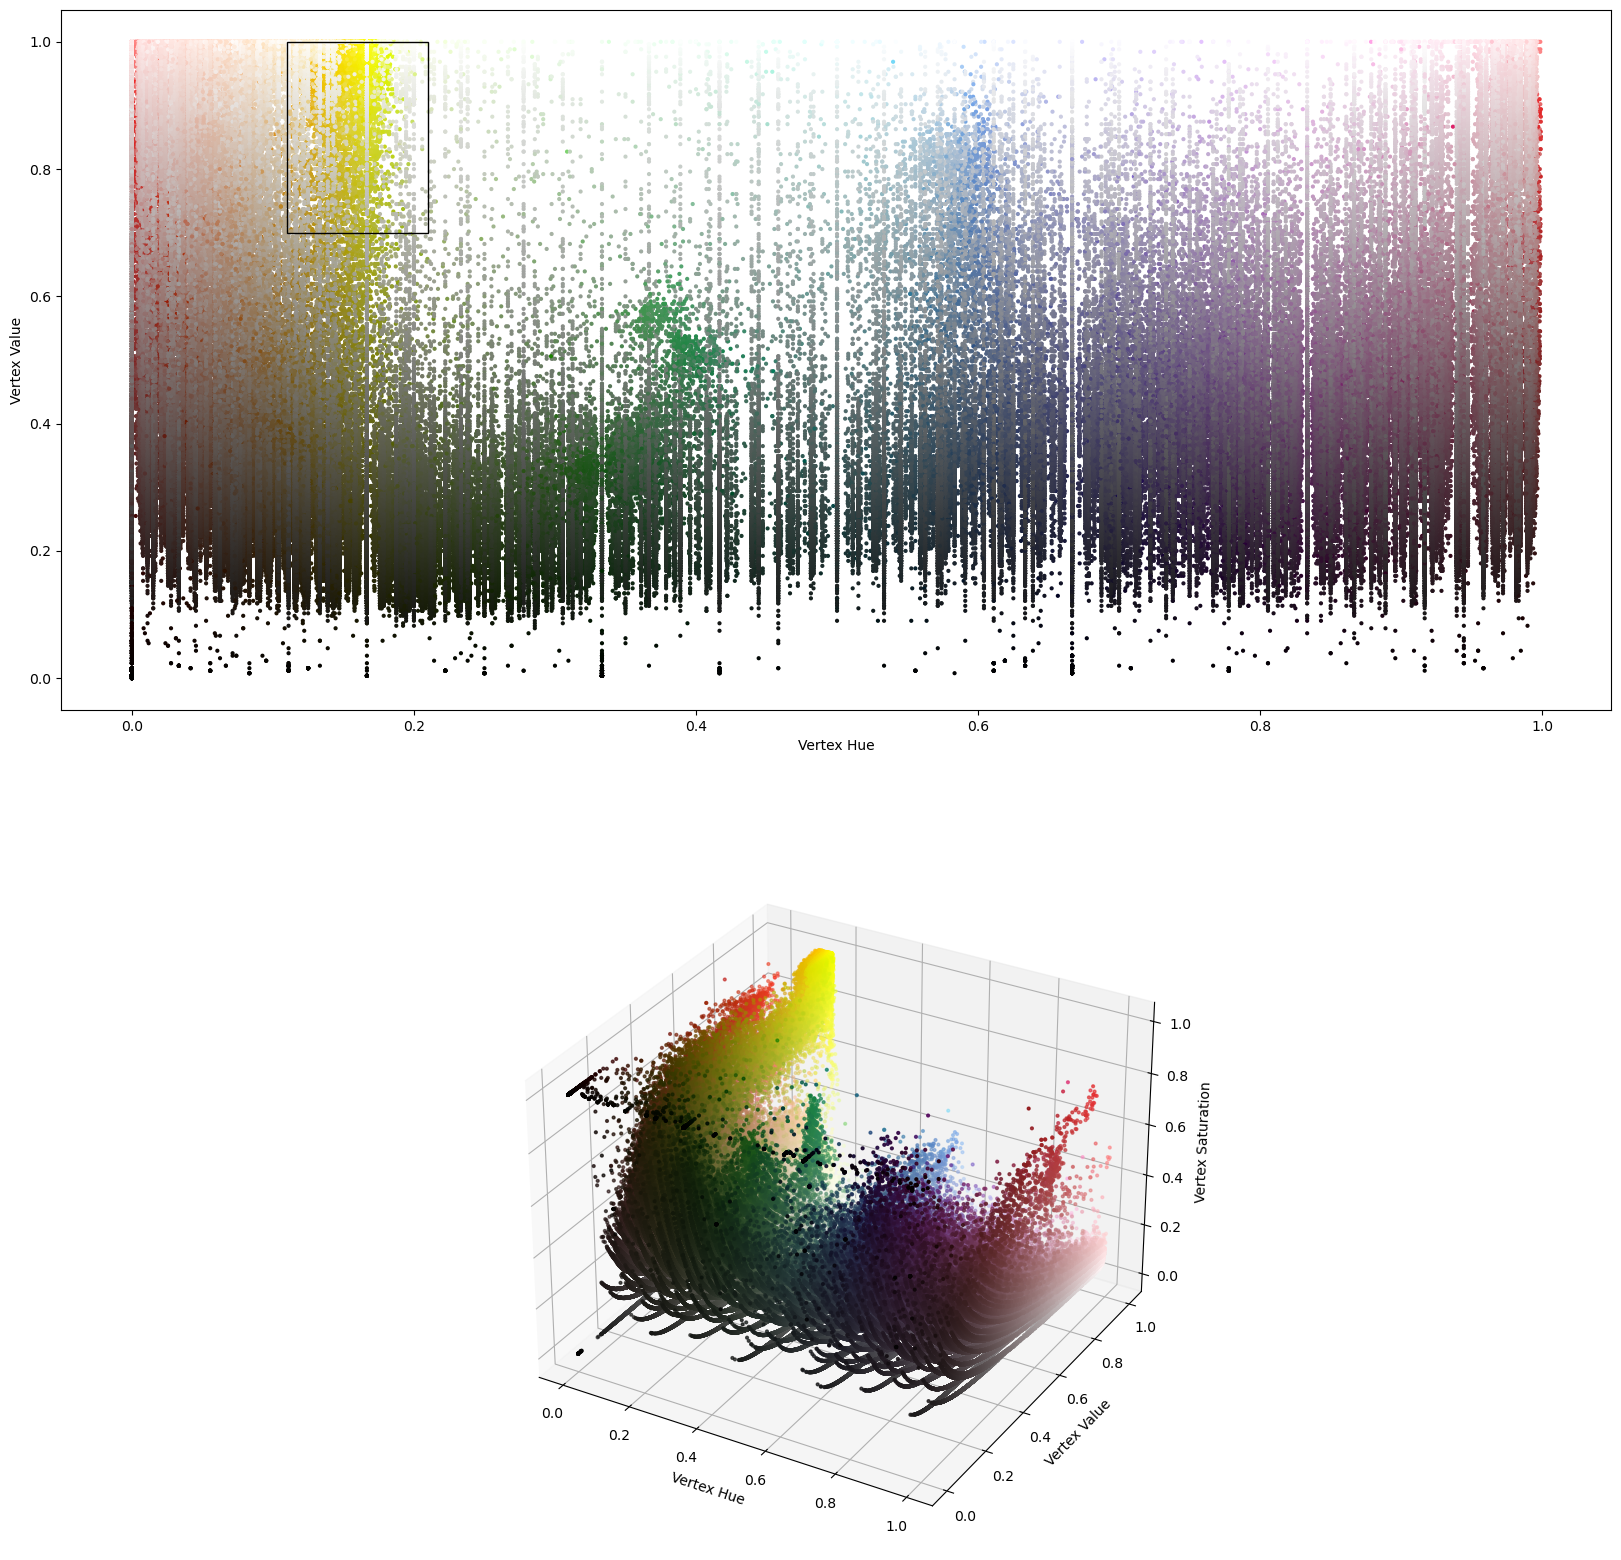

In [122]:
details.plot_vertex_colors()

The following plots show for each cluster (tentative group of sticker vertices) The vertex positions perpendicular to the sticker normal as well as the minimum enclosing circle which is used to find the sticker's center.

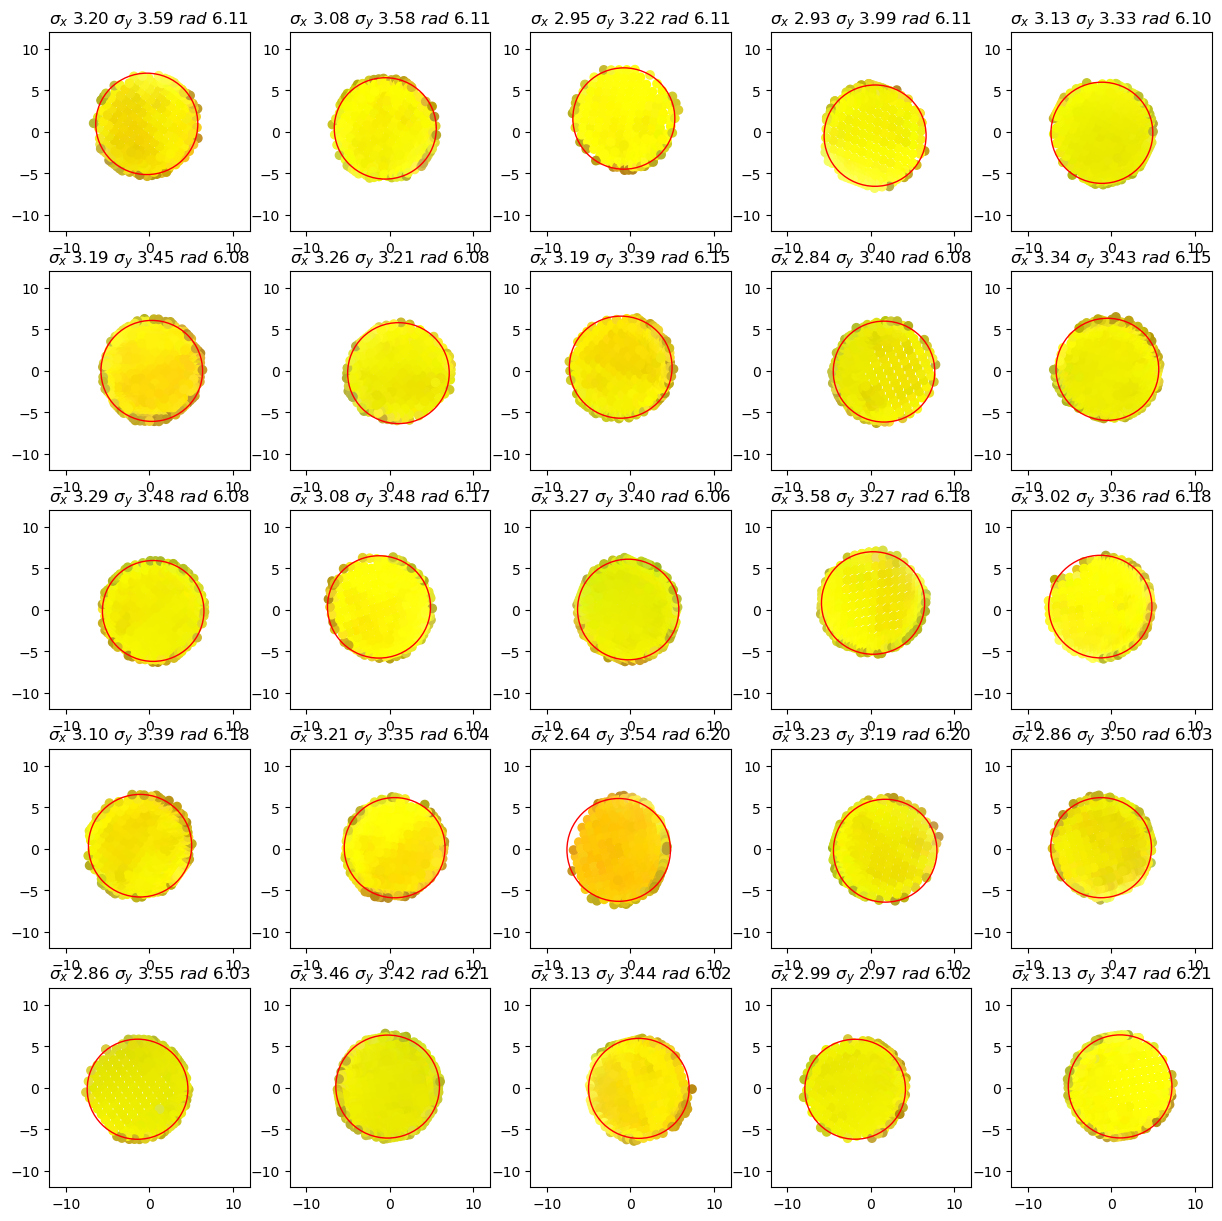

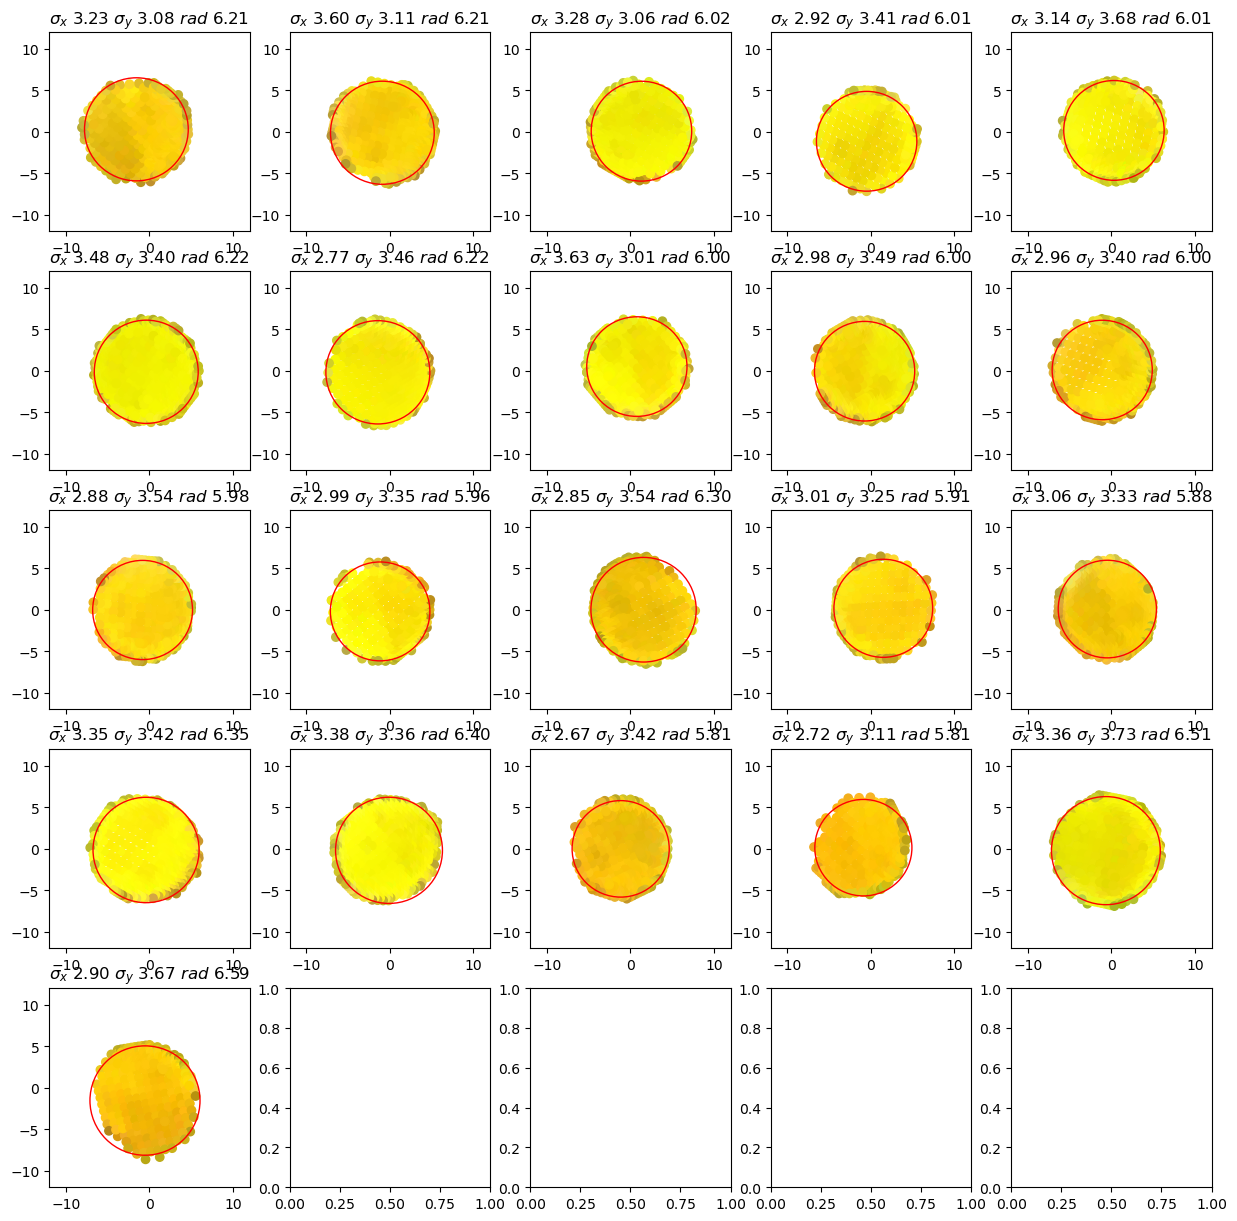

In [123]:
details.plot_cluster_circles()

### [WIP] If not all optodes were found automatically, there's way to remove or add them manually

In [139]:
visualizer = OptodeSelector(s, sticker_centers, normals)
visualizer.plot()
visualizer.enable_picking()
cedalion.plots.plot_surface(visualizer.plotter, s, opacity=1.0)
visualizer.plotter.show()

Widget(value='<iframe src="http://localhost:54446/index.html?ui=P_0x21fb84d60_47&reconnect=auto" class="pyvist…

After selecting all optodes, update sticker_centers and normals:

In [75]:
sticker_centers = visualizer.points
normals = visualizer.normals if visualizer.normals is not None else normals

### [WIP END]...and now continue further

Finally, to get from the sticker centers to the scalp coordinates we have to subtract the lenght of the optodes in the direction of the normals:

In [89]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]

In [90]:
display(scalp_coords)

Magnitude,[[131.12284345040592 9.57514104435086 399.6409098095885] [102.51945120006447 23.898788010172666 275.3228473280257] [116.5957654695105 14.26894220309799 285.9275104139716] [125.73059669121147 -3.8518452459860537 395.07857291077937] [95.21819407033209 73.3860252522379 279.7943843438465] [55.58516691129159 23.828447598731394 267.1340624264369] [111.05851936864707 50.25897147851065 418.27699467912] [91.78516935099407 55.78044408604332 274.49046233399395] [119.84141413223149 21.262550761255824 412.72344909546945] [75.8547909752144 50.05254325889533 269.62090802244364] [98.33185819889981 -2.690294962262179 414.3412623170868] [101.66547826468401 6.5859049484843775 279.09753394661266] [60.76829550947137 61.97631400519812 272.8300388208674] [144.99643205210072 19.84289185078584 389.4764042908354] [99.68208396210737 -5.954975251144081 284.9121105727482] [91.40065743573923 36.103950157720554 271.31597253905574] [72.03058722390236 12.978057894966511 268.7908787721312] [121.94166378026443 49.231731798055144 286.27014612441417] [102.62685175269593 12.968161267002383 419.5109152622475] [98.6403511263532 62.6990391563978 424.45669882914274] [79.56423309910252 -8.336617955607222 416.41029980510973] [77.80676449195661 39.192965463639126 429.12261230107384] [87.73226677393998 18.369181242158707 269.84475896694806] [116.09593677125224 4.978850295109063 409.0489872091909] [84.96644119036256 2.807518547560976 274.45593806941787] [85.71244059082466 9.000122072325833 422.1996960446305] [67.21127248667955 3.2394472429774046 423.0930711918804] [59.332396480643034 44.85120098639544 267.78175051546816] [134.70567357902388 27.958168920759825 402.95678608671227] [133.7911797659541 36.43462119206919 293.7874303618144] [74.24766786635605 29.90452162510272 267.49923626576015] [113.22908984157415 -11.537524084009025 403.3656203729055] [95.29747555370449 45.50240000607409 425.4662573119134] [71.88771996238354 21.237786631737674 427.6644703961249] [82.70079009457845 84.85781928229186 281.665971654588] [107.84935151767851 31.98554221658966 422.0000475612113] [119.35166431903707 30.377086958367194 283.1731669905176] [77.55190968696769 66.57646852393391 273.99394403938777] [123.47520575629636 39.64436227052517 413.07355606669296] [54.91722109526824 18.278228616310884 428.3886424910357] [96.81450302910395 -16.36131886126279 406.1972693467897] [108.05490150029155 -22.786916415669538 392.278378988139] [90.20635585270063 26.793163933613403 426.1198118589382] [108.75963542329531 62.57965941578577 282.12403080675506] [39.694314973833684 37.709729516448164 268.7625514432388] [107.58064774833692 44.55402327542256 277.61060702551237]]
Units,millimeter


In [91]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=0.3)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:54446/index.html?ui=P_0x21fbdceb0_26&reconnect=auto" class="pyvist…

### Select landmarks on a head surface
* pick_landmarks parameter is set to *True*

In [24]:
plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, s, opacity=1.0, pick_landmarks = True)
plt.show()

Widget(value='<iframe src="http://localhost:61955/index.html?ui=P_0x1ab93fd60_3&reconnect=auto" class="pyvista…

### Get landmarks from the plot
Call *get_landmarks* from the previous cell. 
* 1st value - coordinates of picked landmarks
* 2nd - labels of corresponding landmarks

In [26]:
landmark_coordinates, landmark_labels = get_landmarks()
landmark_labels

['Nz', 'Rpa', 'Iz', 'Lpa', 'Cz']

### Write landmarks to xarray.DataArray structure

* insert *landmark_coordinates* and *landmark_labels*

In [27]:
coordinates = landmark_coordinates
labels = landmark_labels

types = [cdc.PointType.LANDMARK]*5
groups = ["L"]*5

landmarks = xr.DataArray(
    np.vstack(coordinates),
    dims=["label", "digitized"],
    coords={
        "label": ("label", labels),
        "type": ("label", types),
        "group": ("label", groups),
    },
).pint.quantify("mm")

display(landmarks)

Magnitude,[[128.02502372334544 117.27483937710178 358.8505894426141] [45.065026390714124 100.82293388726606 288.76791073958225] [-34.4367196489072 34.003963278144965 355.28282855504614] [55.70619943397512 75.12407874220654 432.9285539523837] [124.65765202182132 -13.464092934244377 334.0099374954269]]
Units,millimeter


### Load the montage information from .snirf file


In [28]:
path_to_snirf_file = ""
elements = cedalion.io.read_snirf(path_to_snirf_file)
montage_elements = elements[0].geo3d
#geo3d_meas = geo3d_meas.points.rename({"NASION" : "Nz"})
montage_elements = montage_elements.rename({"pos" : "aligned"})
montage_elements

INFO:root:Loading from file ../2024-02-05_013.snirf
INFO:root:IndexedGroup MeasurementList at /nirs/data1 in ../2024-02-05_013.snirf initalized with 200 instances of <class 'snirf.pysnirf2.MeasurementListElement'>
INFO:root:IndexedGroup Data at /nirs in ../2024-02-05_013.snirf initalized with 1 instances of <class 'snirf.pysnirf2.DataElement'>
INFO:root:IndexedGroup Stim at /nirs in ../2024-02-05_013.snirf initalized with 5 instances of <class 'snirf.pysnirf2.StimElement'>
INFO:root:IndexedGroup Aux at /nirs in ../2024-02-05_013.snirf initalized with 17 instances of <class 'snirf.pysnirf2.AuxElement'>
INFO:root:IndexedGroup Nirs at / in ../2024-02-05_013.snirf initalized with 1 instances of <class 'snirf.pysnirf2.NirsElement'>
INFO:root:Closing Snirf file ../2024-02-05_013.snirf


Magnitude,[[-77.817871 15.680613999999998 23.172269999999997] [-61.906841 21.227732000000003 56.492802] [-85.37146 -16.079958 8.900885] ... [77.521 28.883 -39.113] [80.59 14.229 -38.278] [81.95 -0.678 -37.027]]
Units,millimeter


### Find a transformation to align selected landmarks to montage coordinates

In [29]:
trafo = cedalion.geometry.registration.register_trans_rot(landmarks, montage_elements)


Visualization of initial alignment of optode positions from .snirf file

* Blue for detectors
* Red for sources


In [30]:
filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo)
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, filtered_montage_elements_t, None, plotter = plt) 
plt.show()


Widget(value='<iframe src="http://localhost:61955/index.html?ui=P_0x1ab74a8f0_4&reconnect=auto" class="pyvista…

### Iterative closest point algorithm to find labels for detectes optode centers

In [31]:
transformed_opt_centers, transformation_params, idx = icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 200) 

Extract labels for detected optodes

In [32]:
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

#reference_labels = [None] * len(filtered_data.coords['label'].values)  # Placeholder for the actual size of reference_points
# Use the indices from the ICP query to assign labels
#for target_idx, ref_idx in enumerate(l):
    # The target_idx is the index in target_points, which maps to the actual label in 'lab'
#    if target_idx in lab:
        # Assign the label from target_points (filtered_data) to the matched reference_point
#        reference_labels[ref_idx] = lab[target_idx]
#print(reference_labels)

#scalp_coords = scalp_coords.assign_coords(label=labels)


Visualization of labels assignment

* Green points represent optode centers
* Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)

In [33]:
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="green", show_labels = True, labels = labels)
plt.show()

Widget(value='<iframe src="http://localhost:61955/index.html?ui=P_0x1ab82f370_5&reconnect=auto" class="pyvista…

### If labels are wrong

User is being asked to manually label 3 optodes by selecting them in a given order

Determination of evenly spreaded optodes across the head surface:

In [34]:
spread_point_labels = find_spread_points(filtered_montage_elements)
print("Select those points")
print(spread_point_labels)

points = []
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r", ppoints = points)
#cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

/usr/local/Caskroom/miniforge/base/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Select those points
['S1' 'D32' 'D10']


Widget(value='<iframe src="http://localhost:61955/index.html?ui=P_0x1aa594ee0_6&reconnect=auto" class="pyvista…

(index of points for debugging purposes)

In [255]:
labeled_points = points
labeled_points

[6, 14, 33]

Write the selected labels to the corresponding points of *xarray.DataArray scalp_coords*

In [254]:
new_labels = scalp_coords.label.values.copy()
for i,idx in enumerate(labeled_points): 
    new_labels[idx] = spread_point_labels[i]
scalp_coords = scalp_coords.assign_coords(label=new_labels)
scalp_coords

Magnitude,[[131.12284345040592 9.57514104435086 399.6409098095885] [102.51945120006447 23.898788010172666 275.3228473280257] [116.5957654695105 14.26894220309799 285.9275104139716] [125.73059669121147 -3.8518452459860537 395.07857291077937] [95.21819407033209 73.3860252522379 279.7943843438465] [55.58516691129159 23.828447598731394 267.1340624264369] [111.05851936864707 50.25897147851065 418.27699467912] [91.78516935099407 55.78044408604332 274.49046233399395] [119.84141413223149 21.262550761255824 412.72344909546945] [75.8547909752144 50.05254325889533 269.62090802244364] [98.33185819889981 -2.690294962262179 414.3412623170868] [101.66547826468401 6.5859049484843775 279.09753394661266] [60.76829550947137 61.97631400519812 272.8300388208674] [144.99643205210072 19.84289185078584 389.4764042908354] [99.68208396210737 -5.954975251144081 284.9121105727482] [91.40065743573923 36.103950157720554 271.31597253905574] [72.03058722390236 12.978057894966511 268.7908787721312] [121.94166378026443 49.231731798055144 286.27014612441417] [102.62685175269593 12.968161267002383 419.5109152622475] [98.6403511263532 62.6990391563978 424.45669882914274] [79.56423309910252 -8.336617955607222 416.41029980510973] [77.80676449195661 39.192965463639126 429.12261230107384] [87.73226677393998 18.369181242158707 269.84475896694806] [116.09593677125224 4.978850295109063 409.0489872091909] [84.96644119036256 2.807518547560976 274.45593806941787] [85.71244059082466 9.000122072325833 422.1996960446305] [67.21127248667955 3.2394472429774046 423.0930711918804] [59.332396480643034 44.85120098639544 267.78175051546816] [134.70567357902388 27.958168920759825 402.95678608671227] [133.7911797659541 36.43462119206919 293.7874303618144] [74.24766786635605 29.90452162510272 267.49923626576015] [113.22908984157415 -11.537524084009025 403.3656203729055] [95.29747555370449 45.50240000607409 425.4662573119134] [71.88771996238354 21.237786631737674 427.6644703961249] [82.70079009457845 84.85781928229186 281.665971654588] [107.84935151767851 31.98554221658966 422.0000475612113] [119.35166431903707 30.377086958367194 283.1731669905176] [77.55190968696769 66.57646852393391 273.99394403938777] [123.47520575629636 39.64436227052517 413.07355606669296] [54.91722109526824 18.278228616310884 428.3886424910357] [96.81450302910395 -16.36131886126279 406.1972693467897] [108.05490150029155 -22.786916415669538 392.278378988139] [90.20635585270063 26.793163933613403 426.1198118589382] [108.75963542329531 62.57965941578577 282.12403080675506] [39.694314973833684 37.709729516448164 268.7625514432388] [107.58064774833692 44.55402327542256 277.61060702551237]]
Units,millimeter


Find the affine transformation for the newly labeled points

In [258]:
trafo2 = cedalion.geometry.registration.register_trans_rot(scalp_coords, montage_elements)

and apply it to the montage optodes

In [259]:
filtered_montage_elements = montage_elements.where((montage_elements.type == cdc.PointType.SOURCE) | (montage_elements.type == cdc.PointType.DETECTOR), drop=True)
filtered_montage_elements_t = filtered_montage_elements.points.apply_transform(trafo2)

and run ICP algorithm for label assignment once again

In [260]:
transformed_opt_centers, transformation_params, idx = icp_with_full_transform(scalp_coords, 
                                                                            filtered_montage_elements_t, max_iterations = 200) 

Extract labels for detected optodes

In [261]:
label_dict = {}
for i, label in enumerate(filtered_montage_elements.coords['label'].values):
    label_dict[i] = label
labels = [label_dict[index] for index in idx]

Visualization of labels assignment

* Green points represent optode centers
* Next to them there shall be labels assumed by ICP algorithm (*show_labels = True*)

In [263]:
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="green", show_labels = True, labels = labels)
plt.show()

Widget(value='<iframe src="http://localhost:49714/index.html?ui=P_0x3af33b490_132&reconnect=auto" class="pyvis…

If labels are correct, then can be written to the xarray.DataArray scalp_coords

In [264]:
scalp_coords = scalp_coords.assign_coords(label=labels)

Visualization of successfull assignment *(show_labels = True)*

In [267]:
plt = pv.Plotter()
cedalion.plots.plot3d(None, s.mesh, None, None, plotter = plt) 
cedalion.plots.plot_labeled_points(plt, scalp_coords, show_labels = True, color="green")
plt.show()

Widget(value='<iframe src="http://localhost:49714/index.html?ui=P_0x3c12f32e0_135&reconnect=auto" class="pyvis…